In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
from PIL import Image
import glob
import random 
import os
import matplotlib.pyplot as plt
import faiss
import numpy as np

In [2]:
DB_DIR = '../data/db'

In [3]:
# # Load pre-trained ResNet50 model
# class FeatureExtractor(torch.nn.Module):
#     def __init__(self):
#         super(FeatureExtractor, self).__init__()
#         model = models.resnet50(pretrained=True)
#         self.feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # Remove last layer

#     def forward(self, x):
#         x = self.feature_extractor(x)
#         return x.view(x.size(0), -1)  # Flatten output
    
# # Initialize model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# feature_extractor = FeatureExtractor().to(device).eval()


# # Define image transformation
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])


# def extract_cnn_features(image):
#     """Extracts feature embeddings using ResNet50."""
#     image = transform(image).unsqueeze(0).to(device)
    
#     with torch.no_grad():
#         features = feature_extractor(image).cpu().numpy().flatten()
    
#     return features  # Return feature embedding

In [12]:
class CNNFeatureExtractor(torch.nn.Module):
    def __init__(self, device=None):
        super(CNNFeatureExtractor, self).__init__()
        self.model = models.resnet101(pretrained=True)
        self.feature_model = torch.nn.Sequential(*list(self.model.children())[:-1])
        self.transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                            ])
        self.device =  device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        self.eval()
        
    def forward(self, x):
        x = self.feature_model(x)
        return x.view(x.size(0), -1)  # Flatten output
        # return x
        # return torch.flatten(x)
    
    def get_features(self, image):
        image = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            features = self.forward(image).cpu().numpy().flatten()
            # features = self.forward(image).cpu().numpy()
            # features = torch.nn.functional.normalize(features, dim=0)
            
        return features

In [13]:
embedding_model = CNNFeatureExtractor()
img = Image.open('../data/test_output/cropped_image_5.jpg')
embedding = embedding_model.get_features(img)
len(embedding)

c:\Users\HP\Desktop\E-Vision-Projects\Merchandiser_Products_Counter\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\Desktop\E-Vision-Projects\Merchandiser_Products_Counter\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2048

In [16]:
class FaissManager:
    def __init__(self, embedding_dim):
        self.index = faiss.IndexFlatIP(embedding_dim)
        
    def add_reference_images(self, embeddings, index_path):
        vector = np.array(embeddings).astype(np.float32)
        self.index.add(vector)
        faiss.write_index(self.index, index_path)
        return self.index
    
    def load_index(self, index_path):
        self.index = faiss.read_index(index_path)
        return self.index
    
    def find_similarity(self, query_embedding, index_path, top_k = 3):
        self.index = self.load_index(index_path=index_path)
        
        query_features = query_embedding.astype(np.float32).reshape(1, -1)
        
        distances, indices = self.index.search(query_features, top_k)
        
        return distances, indices

In [17]:
db_images = os.listdir(DB_DIR)

In [18]:
db_image_paths = glob.glob(os.path.join(DB_DIR, '*/*.jpg'))

In [19]:
class DBEmbedding:
    def __init__(self, model):
        self.image_path = []
        self.embedding_lis = []
        self.model = model
    def get_db_embedding(self, db_dir):
        self.image_path = glob.glob(os.path.join(db_dir, '*/*.jpg'))
        for img in self.image_path:
            image = Image.open(img)
            embedding = self.model.get_features(image)
            self.embedding_lis.append(embedding)
        return self.embedding_lis      

In [20]:
model = CNNFeatureExtractor()

embedding_list = DBEmbedding(model).get_db_embedding(DB_DIR)

c:\Users\HP\Desktop\E-Vision-Projects\Merchandiser_Products_Counter\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\Desktop\E-Vision-Projects\Merchandiser_Products_Counter\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
len(embedding_list[0])

2048

In [22]:
embedding_dim = len(embedding_list[0])
embedding_dim

2048

In [23]:
faiss_manager = FaissManager(embedding_dim=embedding_dim)

In [24]:
INDEX_PATH = '../data/faiss_data/vector.index'

faiss_manager.add_reference_images(embeddings=embedding_list, index_path=INDEX_PATH)

<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x0000020F875EA490> >

In [25]:
query_image = '../data/test_output/cropped_image_3.jpg'
query_embedding = model.get_features(Image.open(query_image))

In [26]:
distances, indices = faiss_manager.find_similarity(query_embedding=query_embedding, index_path=INDEX_PATH)

In [27]:
distances, indices

(array([[772.51025, 744.6521 , 733.35315]], dtype=float32),
 array([[ 9, 29, 37]]))

In [28]:
query_images = glob.glob('../data/test_output/*.jpg')

In [29]:
import matplotlib.pyplot as plt

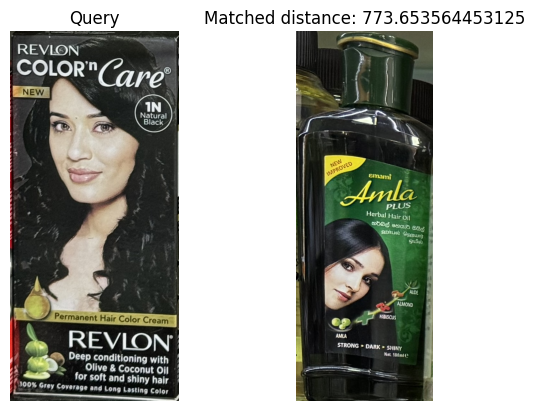

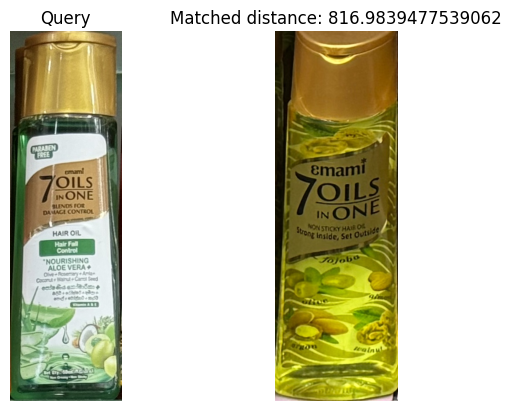

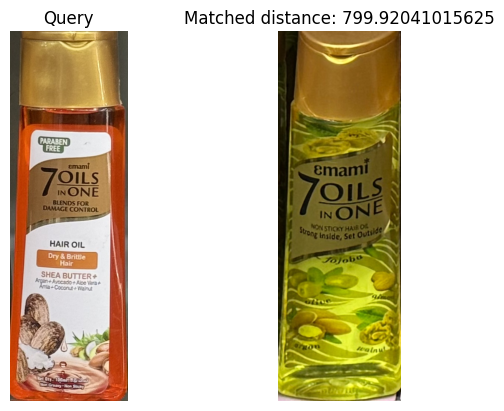

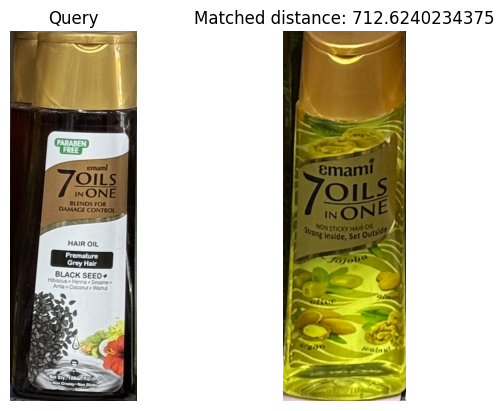

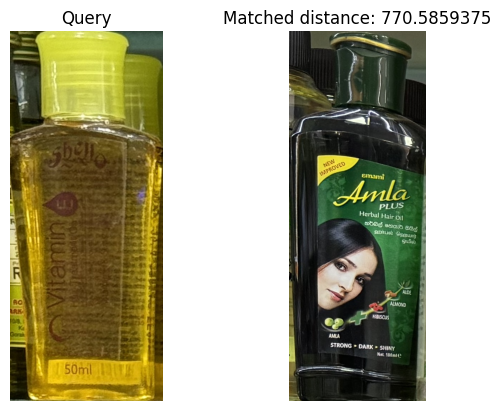

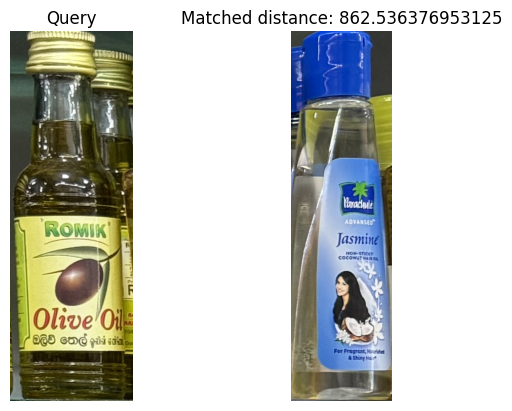

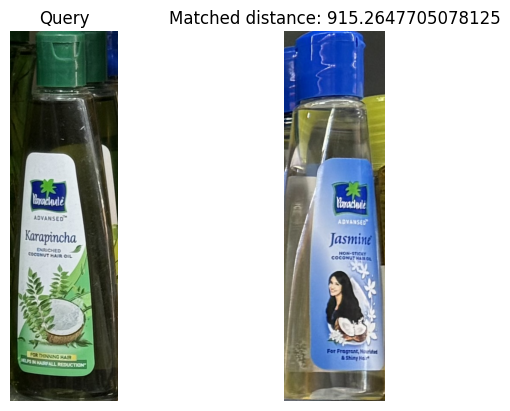

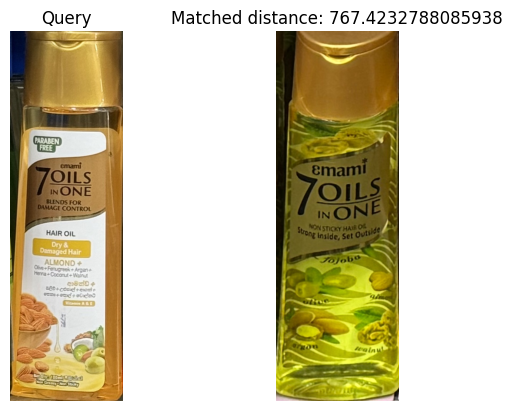

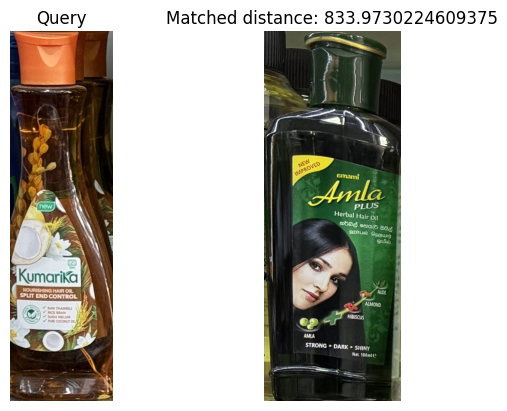

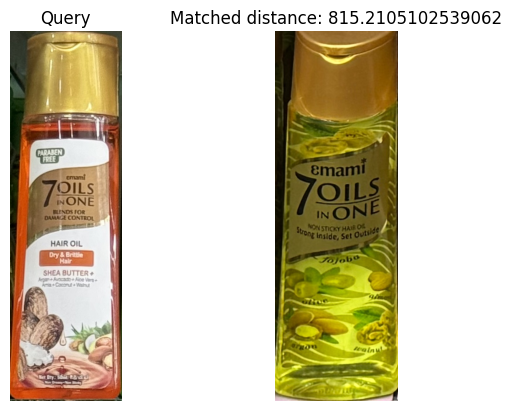

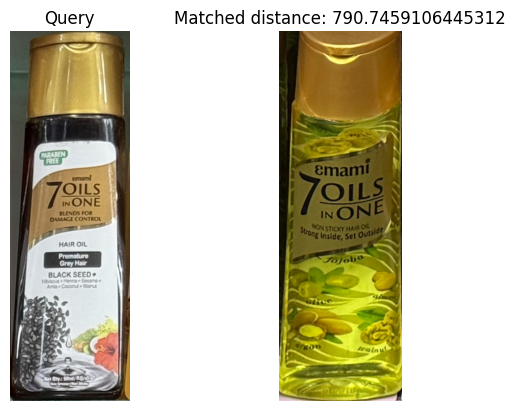

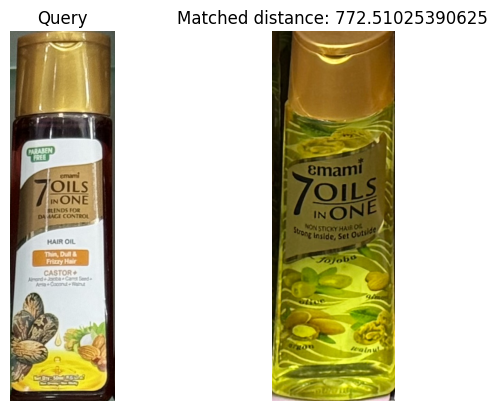

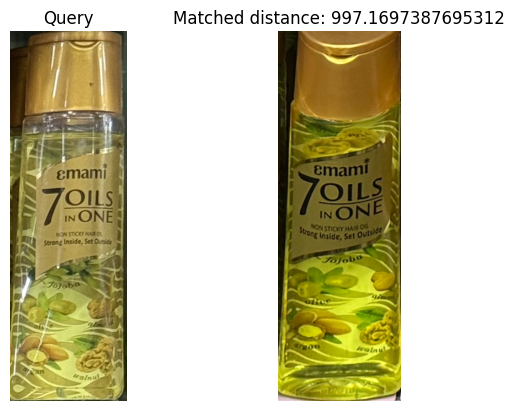

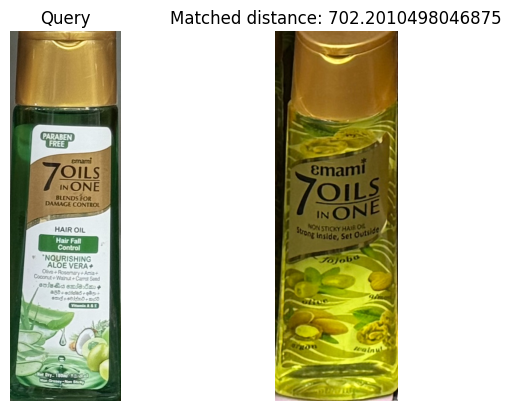

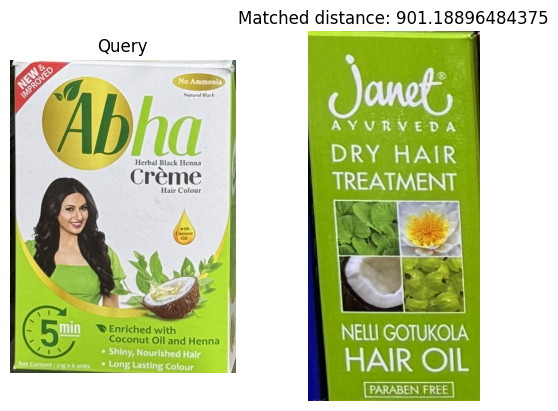

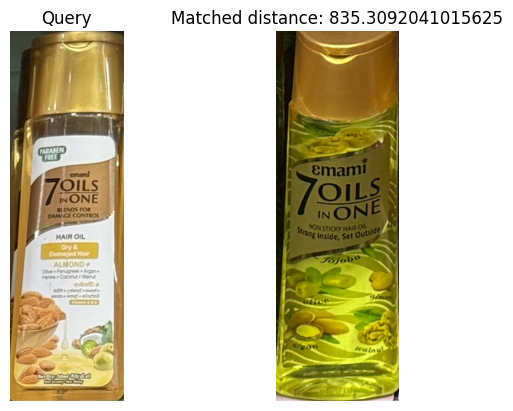

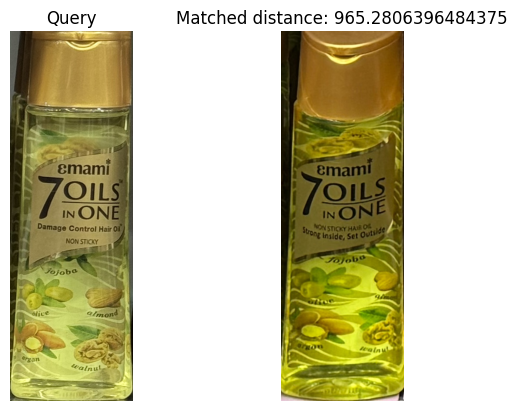

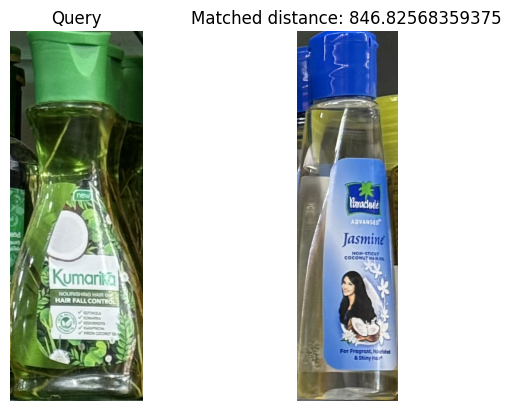

In [30]:
for i, img in enumerate(query_images):
    query_img = Image.open(img)
    query_emb = model.get_features(query_img)
    distances, indices = faiss_manager.find_similarity(query_embedding=query_emb, index_path=INDEX_PATH)
    matched_image = Image.open(db_image_paths[indices[0][0]])
    if distances[0][0] < 0.75:
        continue
    plt.subplot(1,2,1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title("Query")
    
    plt.subplot(1,2,2)
    plt.imshow(matched_image)
    plt.axis('off')
    plt.title(f"Matched distance: {distances[0][0]}")
    plt.show()